# Calibration of an Inertial Sensor

Text(0.5, 0, 'Frequency (Hz)')

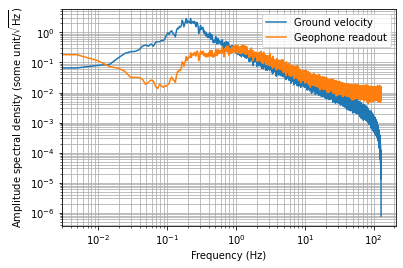

In [1]:
import control
import numpy as np
import matplotlib.pyplot as plt
import scipy

import kontrol.curvefit


np.random.seed(123)  # Fix the random seed so it's reproducible.
fs = 256  # Hz
t = np.linspace(0, 1024, 1024*fs)
s = control.tf("s")

# Simulate measurement data (replace this part with real measurements)
# Obtain some ground motion.
# Shape of the ground velocity spectrum
ground_tf = s*(0.2*2*np.pi)**2 / (s**2 + (0.2*2*np.pi)/(2)*s + (0.2*2*np.pi)**2)
random = np.random.normal(loc=0, scale=np.sqrt(fs/2), size=len(t))
_, ground_velocity = control.forced_response(ground_tf, U=random, T=t)
# ground_velocity is what the seismometer measure.
# For simplicity, let's just assume the seismometer is noiseless so it reads exactly ground_velocity.

# The geophone is not noiseless so it reads slightly different fro the seismometer.
# Generate the analog-to-digital converter noise.
adc_noise_tf = 10**(-2)/s*(s+0.1*2*np.pi)
random2 = np.random.normal(loc=0, scale=np.sqrt(fs/2), size=len(t))
_, adc_noise = control.forced_response(adc_noise_tf, U=random2, T=t)

# Define the geophone transfer function (We don't know these values yet!)
G = 1.5
wn = 1*2*np.pi
Q = 1/np.sqrt(2)
geophone_tf = G * s**2 / (s**2 + wn/Q*s + wn**2)


# Generate the geophone readout
_, geophone_readout = control.forced_response(geophone_tf, U=ground_velocity, T=t)
geophone_readout += adc_noise  # Add ADC noise


# Here's what we measured
f, ground_psd = scipy.signal.welch(ground_velocity, fs=1/(t[1]-t[0]), nperseg=int(len(t)/5))
_, geophone_psd = scipy.signal.welch(geophone_readout, fs=1/(t[1]-t[0]), nperseg=int(len(t)/5))

plt.loglog(f, ground_psd**0.5, label="Ground velocity")
plt.loglog(f, geophone_psd**0.5, label="Geophone readout")
plt.legend(loc=0)
plt.grid(which="both")
plt.ylabel(r"Amplitude spectral density (some unit/$\sqrt{\mathrm{Hz}}$)")
plt.xlabel("Frequency (Hz)")

Text(0.5, 0, 'Frequency (Hz)')

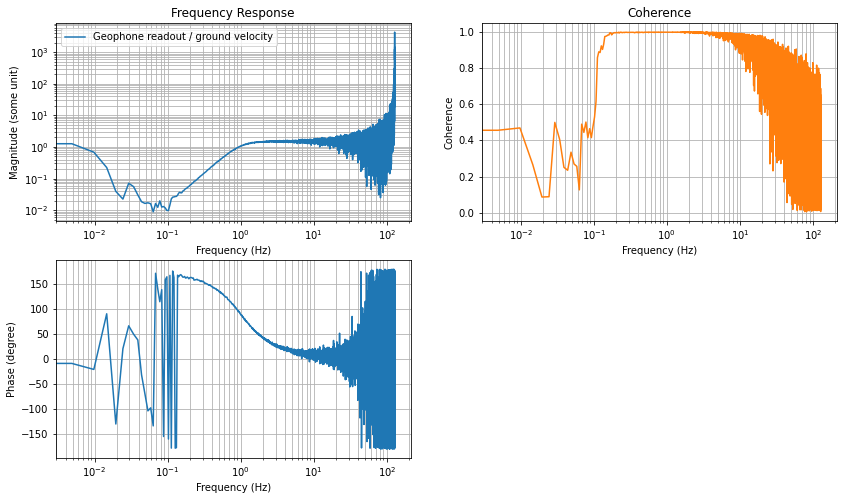

In [2]:
# We can obtain the cross-spectral density between the two signals
# and obtain a frequency response of the geophone and the coherence between the two.
f, ground_geophone_csd = scipy.signal.csd(ground_velocity, geophone_readout, fs=1/(t[1]-t[0]), nperseg=int(len(t)/5))
frequency_response = ground_geophone_csd/ground_psd
coherence = abs(ground_geophone_csd) / (ground_psd*geophone_psd)**0.5
# ^The data can be obtained from the digital system directly.
# If you're working with real data, you should be able to skip everything above.

plt.figure(figsize=(14, 8))
plt.subplot(221)
plt.title("Frequency Response")
plt.loglog(f, abs(frequency_response), label="Geophone readout / ground velocity")
plt.legend(loc=0)
plt.grid(which="both")
plt.ylabel(r"Magnitude (some unit)")
plt.xlabel("Frequency (Hz)")

plt.subplot(223)
plt.semilogx(f, 180/np.pi*np.angle(frequency_response), label="Frequency response")
plt.grid(which="both")
plt.ylabel(r"Phase (degree)")
plt.xlabel("Frequency (Hz)")

plt.subplot(222)
plt.title("Coherence")
plt.semilogx(f, coherence, color="C1", label="Coherence")
plt.grid(which="both")
plt.ylabel("Coherence")
plt.xlabel("Frequency (Hz)")

In [3]:
# As can be seen, the two signals are not perfectly coherence at all frequencies.
# We should pick out the part where they have good coherence,
# i.e. where the geophone is measuring the ground motion, but not noise.
# The coherence function is a good tool for this.
# Let's pick out the frequency response data where coherence is larger than 0.99
frequency_response_pick = frequency_response[coherence>0.99]
f_pick = f[coherence>0.99]
# This is the data that we want to fit.

In [4]:
# Fitting with kontrol.curvefit.TransferFunctionFit.
# To use it, we need to specify a few attributes.
# We need to select the x_data, y_data, model, optimizer, and optimizer_kwargs.
curvefit = kontrol.curvefit.TransferFunctionFit()
curvefit.xdata = f_pick
curvefit.ydata = frequency_response_pick

# Kontrol.curvefit.model has a library of generic models for fitting.
# However, let's just define our own geophone model for the sake of understanding what's happening.
# Model has a signature func(x, args, **kwargs)->array
# x is the independent variable and args are the parameters that define the model.
def model(x, args):
    G, wn, Q = args
    s = control.tf("s")
    geophone_tf = G * s**2 / (s**2+wn/Q*s+wn**2)
    return geophone_tf(1j*2*np.pi*x)

curvefit.model = model

# Normally, we don't need to specify the optimizer.
# By default it's using scipy.optimizer.minimize, which is a local optimizer.
# It requires initial guess of the G, wn, and Q to start optimizing.
# It's easy enough to obtain the inital guess from specifications.
# But let's just assume we don't know any of that but we know a range for those parameters.
# In this case, we can use a global optimization algorithm.
curvefit.optimizer = scipy.optimize.differential_evolution

# We know G is the high-frequency gain, from the plot, it falls between 0.1 and 10.
# We know wn is the corner frequency and it falls between 0.1 and 10 Hz or 0.1*2*np.pi and 10*2*np.pi rad/s
# We know Q value is the height at the corner frequency and it falls between 0.5 and 10.
bounds = [(0.1, 10), (0.1*2*np.pi, 10*2*np.pi), (0.5, 10)]  # Try widening the bounds except for 0.5 for the Q.
curvefit.optimizer_kwargs = {"bounds": bounds}
result = curvefit.fit()  # This returns a scipy.optimize.OptimizeResult object.

In [5]:
# To obtain the model parameters, use result.x
G_fit, wn_fit, Q_fit = result.x

# Let's reconstruct the fitted geophone transfer function
geophone_tf_fit = G_fit * s**2 / (s**2+wn_fit/Q_fit*s+wn_fit**2)

# Compare the true transfer function and the fit
print("True geophone transfer function:", geophone_tf)
print("Fitted geophone transfer function:", geophone_tf_fit)

True geophone transfer function: 
       1.5 s^2
---------------------
s^2 + 8.886 s + 39.48

Fitted geophone transfer function: 
     1.497 s^2
--------------------
s^2 + 8.87 s + 39.42



In [6]:
# Close enough, let's try to obtain a calibration filter so we can measure velocity with the geophone.
# Recall that the geophone transfer function converts ground velocity
# to geophone output, the inverse of it converts geophone output to ground velocity.
# The inverse is what we need to "calibrate" the geophone.
# And it can be used as a calibration filter in the digital system to get velocity from geophone.
calibration_filter = 1 / geophone_tf_fit

# To install it to the KAGRA digital system, we need to convert the transfer function
# from analytic form to a Foton string.
# Kontrol.TransferFunction object offers this functionality.
calibration_filter = kontrol.TransferFunction(calibration_filter)
# ^Converting itself into a Kontrol.TransferFunction object

foton_string = calibration_filter.foton(root_location="n")
# ^the option is unnesscary but "n" is the one we typically use.
print("This is what we need to put into the digital system:\n", foton_string)
# This is the filter that will convert the geophone readout into velocity.

This is what we need to put into the digital system:
 zpk([0.705852+i*0.707336;0.705852+i*-0.707336],[-0;-0],0.667203,"n")
